In [1]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import shap

from cuml.ensemble import RandomForestRegressor as cuRF
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV 
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

import os
os.chdir("/local-scratch/GlucoseProject/mobicom23_mobispectral/regression")
import sys
sys.path.append(os.getcwd())
from utils import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data understanding

In [ ]:
X, y, image_list_train, image_list_test = get_all_data('../datasets/dataset_skin/regression', 'concatset_train.txt', 'concatset_test.txt', 1)

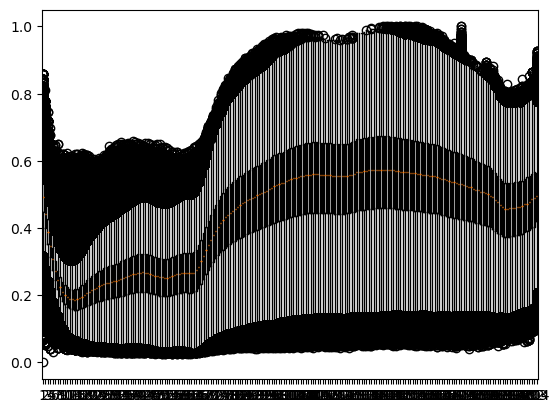

[[1.         0.89720878 0.89077855 ... 0.53931944 0.54253419 0.58604128]
 [0.89720878 1.         0.91476777 ... 0.53371475 0.53842721 0.57984164]
 [0.89077855 0.91476777 1.         ... 0.57926502 0.58346861 0.62256938]
 ...
 [0.53931944 0.53371475 0.57926502 ... 1.         0.98793825 0.96463462]
 [0.54253419 0.53842721 0.58346861 ... 0.98793825 1.         0.96425242]
 [0.58604128 0.57984164 0.62256938 ... 0.96463462 0.96425242 1.        ]]


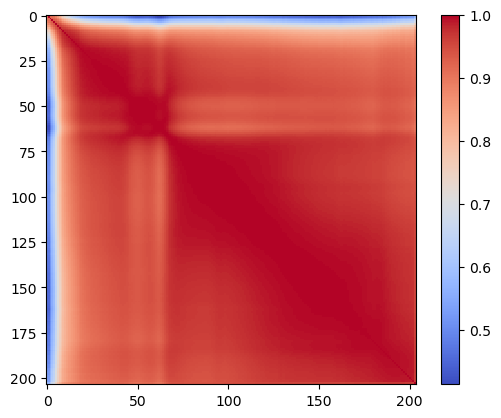

In [7]:
# # Summary statistics
# print("Mean:", np.mean(X, axis=0))
# print("Mean size: ", np.mean(X, axis=0).shape)
# print("Median:", np.median(X, axis=0))
# print("Standard Deviation:", np.std(X, axis=0))

# # Data Types
# print("Data Type:", X.dtype)

# # Missing values
# print("Missing values:", np.isnan(X).sum())

# # Visualizations
# plt.hist(X, bins=200)
# plt.ylabel('Frequency')
# plt.xlabel('signatures value')
# plt.show()

plt.boxplot(X)
plt.show()

# Correlation
correlation_matrix = np.corrcoef(X, rowvar=False)
print(correlation_matrix)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.show()

## Feature understanding

In [2]:
X_train, y_train, X_test, y_test, test_data = prepare_data('../datasets/dataset_skin/regression', 'concatset_train.txt', 'concatset_test.txt', 1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [3]:
# Scale data
# scaler = StandardScaler()
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [5]:
import cupy as cp
X_train = cp.array(X_train)
# X_val = cp.array(X_val)
X_test = cp.array(X_test)

In [4]:
model = XGBRegressor(n_estimators=250
           ,subsample=0.5236842105263158
           ,random_state=42
           ,tree_method='hist'
           ,device='cuda'
           ,n_job=-1
           ,learning_rate=0.1)

In [7]:
X_train = cp.asnumpy(X_train)
# X_val = cp.asnumpy(X_val)
X_test = cp.asnumpy(X_test)

In [12]:
BANDS_WAVELENGTHS = [397.32, 400.20, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.40, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.50, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.80, 501.72, 504.64, 507.56, 510.48, 513.40, 516.33, 519.25, 522.18, 525.10, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.30, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.90, 583.85, 586.80, 589.75, 592.70, 595.65, 598.60, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.30, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.60, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.60, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.70, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.50, 868.55, 871.60, 874.64, 877.69, 880.74, 883.79, 886.84, 889.90, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.30, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 938.88, 941.95, 945.02, 948.10, 951.17, 954.24, 957.32, 960.40, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.40, 1000.49, 1003.58]


In [6]:
num_features_to_select = 49

Selected bands:  [ 1 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68]


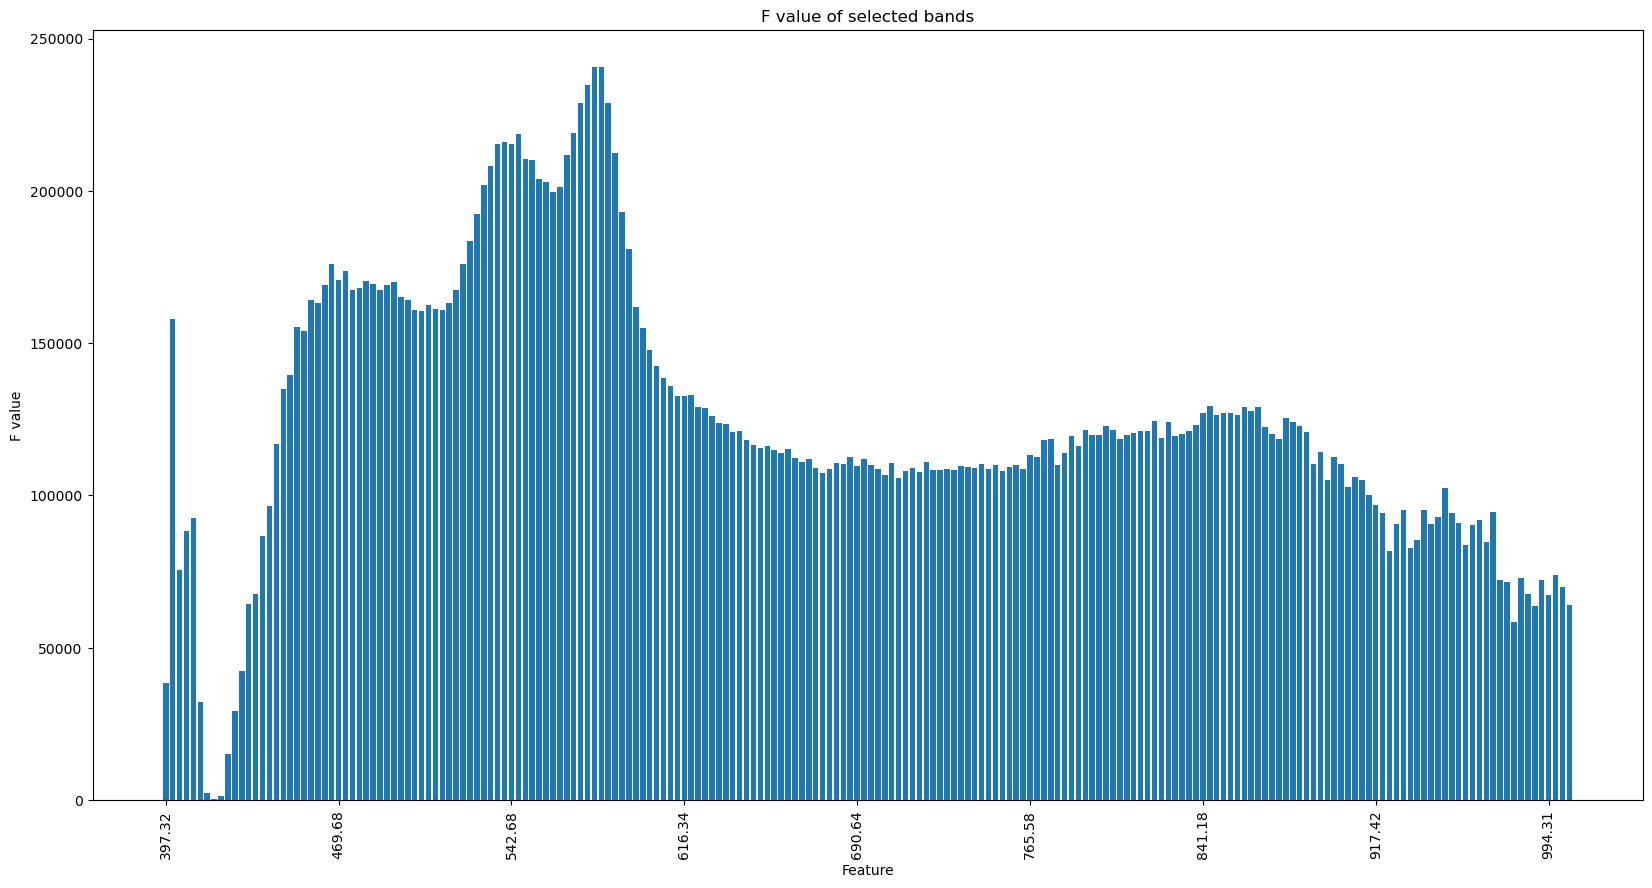

In [10]:
# Robust Scaler, without x_val
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_new = selector.fit_transform(X_train, y_train)

selected_feature_indices = selector.get_support(indices=True)

print('Selected bands: ', selected_feature_indices)

plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), selector.scores_)
plt.xlabel('Feature')
plt.ylabel('F value')
plt.title('F value of selected bands')
# xticks is band wavelengths, but 25 apart from each tick
plt.xticks(range(0, 204, 25), BANDS_WAVELENGTHS[0::25], rotation=90)
plt.show()

Selected bands:  [ 1 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68]


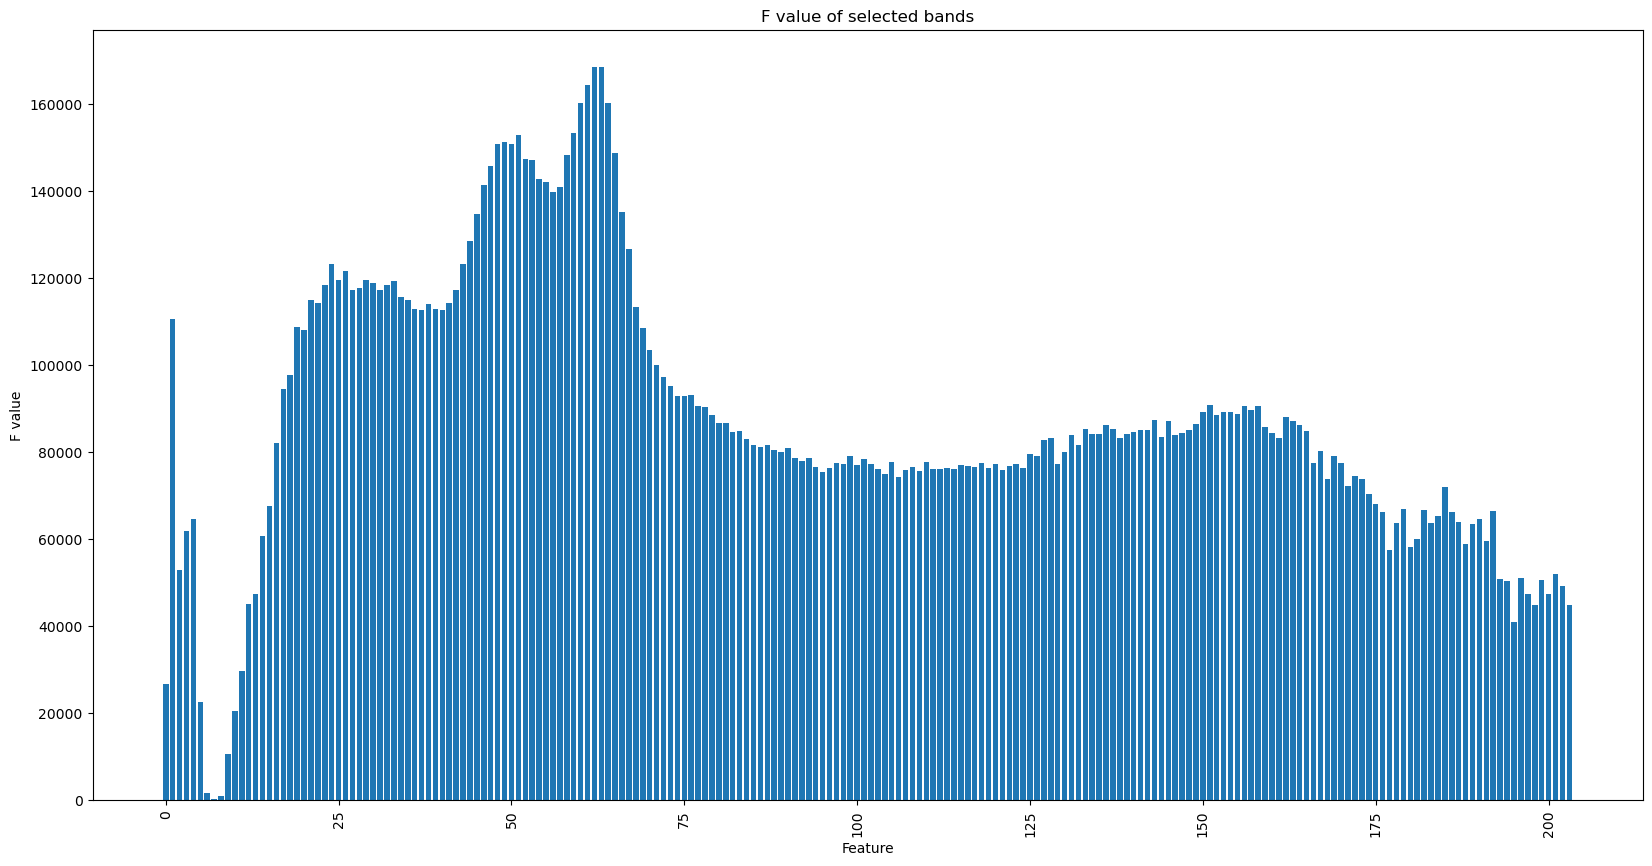

In [35]:
# Standard Scaler, with x_val
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)
X_new = selector.fit_transform(X_train, y_train)

feature_names = np.arange(204)
selected_feature_indices = selector.get_support(indices=True)

print('Selected bands: ', selected_feature_indices)

plt.figure(figsize=(20, 10))
plt.bar(range(len(feature_names)), selector.scores_)
plt.xlabel('Feature')
plt.ylabel('F value')
plt.title('F value of selected bands')
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [5]:

# total_features = X_train.shape[1]
# rfe = RFE(model, n_features_to_select=num_features_to_select)

# # Fit the RFE to the training data
# rfe.fit(X_train, y_train)

# ranking = rfe.ranking_

In [7]:
# ranking

array([  1,   1,   1,   1,   1,   1,   1,   5,   1,   1,  16,  22,  38,
        51,  28,   4,   1,   1,   1,   1,  50,   1,  48,  23,   9,  49,
       106, 155,  71,  89, 118, 157, 132,  81,  57, 137, 110,  83, 133,
       130,  34,  41, 107, 125, 126, 150,  91,  78, 124,  80, 136, 141,
        66, 112,  67, 113,  60,  15,  31, 117, 102,   1,   1,   1,  12,
         2,  76,  39,  53,  40,  84,  68, 105,  98, 127,  97,  99,  45,
        56,  87,  79,  19,  46,   1,  73,  70,  54,  44,  42,  63,  37,
        20, 128, 115,  58,  35,  29,  88, 123, 122, 116,  11, 138, 114,
        62,  21, 156,  24, 134, 173,  13, 151, 163, 171, 109, 101, 162,
       154, 172, 103, 180, 164, 158, 143,  26, 176, 168, 139, 142, 135,
       147, 166, 185, 174, 159, 170,  90, 169, 146, 179, 181, 182, 148,
       175,  47, 104,  36, 184, 165,  94, 178, 160, 167, 129,  64, 144,
        77,  69, 111, 183, 149,  17, 119, 161, 131,  72,  93, 152, 120,
        30,  86, 108, 121,  85, 177,  82, 140,  25, 100,  59,  5

In [13]:
total_features = X_train.shape[1]
num_irrelevant_features_eliminated = np.arange(total_features - 1, -1, -1)
print(num_irrelevant_features_eliminated)

[203 202 201 200 199 198 197 196 195 194 193 192 191 190 189 188 187 186
 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168
 167 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150
 149 148 147 146 145 144 143 142 141 140 139 138 137 136 135 134 133 132
 131 130 129 128 127 126 125 124 123 122 121 120 119 118 117 116 115 114
 113 112 111 110 109 108 107 106 105 104 103 102 101 100  99  98  97  96
  95  94  93  92  91  90  89  88  87  86  85  84  83  82  81  80  79  78
  77  76  75  74  73  72  71  70  69  68  67  66  65  64  63  62  61  60
  59  58  57  56  55  54  53  52  51  50  49  48  47  46  45  44  43  42
  41  40  39  38  37  36  35  34  33  32  31  30  29  28  27  26  25  24
  23  22  21  20  19  18  17  16  15  14  13  12  11  10   9   8   7   6
   5   4   3   2   1   0]


In [13]:
model = XGBRegressor(
        random_state=42
        ,tree_method='hist'
        ,device='cuda'
        ,n_job=-1
        )

In [4]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [6]:
model = cuRF(random_state=42)

In [5]:
# Shap values
shap_model = model
shap_model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(shap_model)
# Compute SHAP values for the test set
shap_values = explainer(X_test)


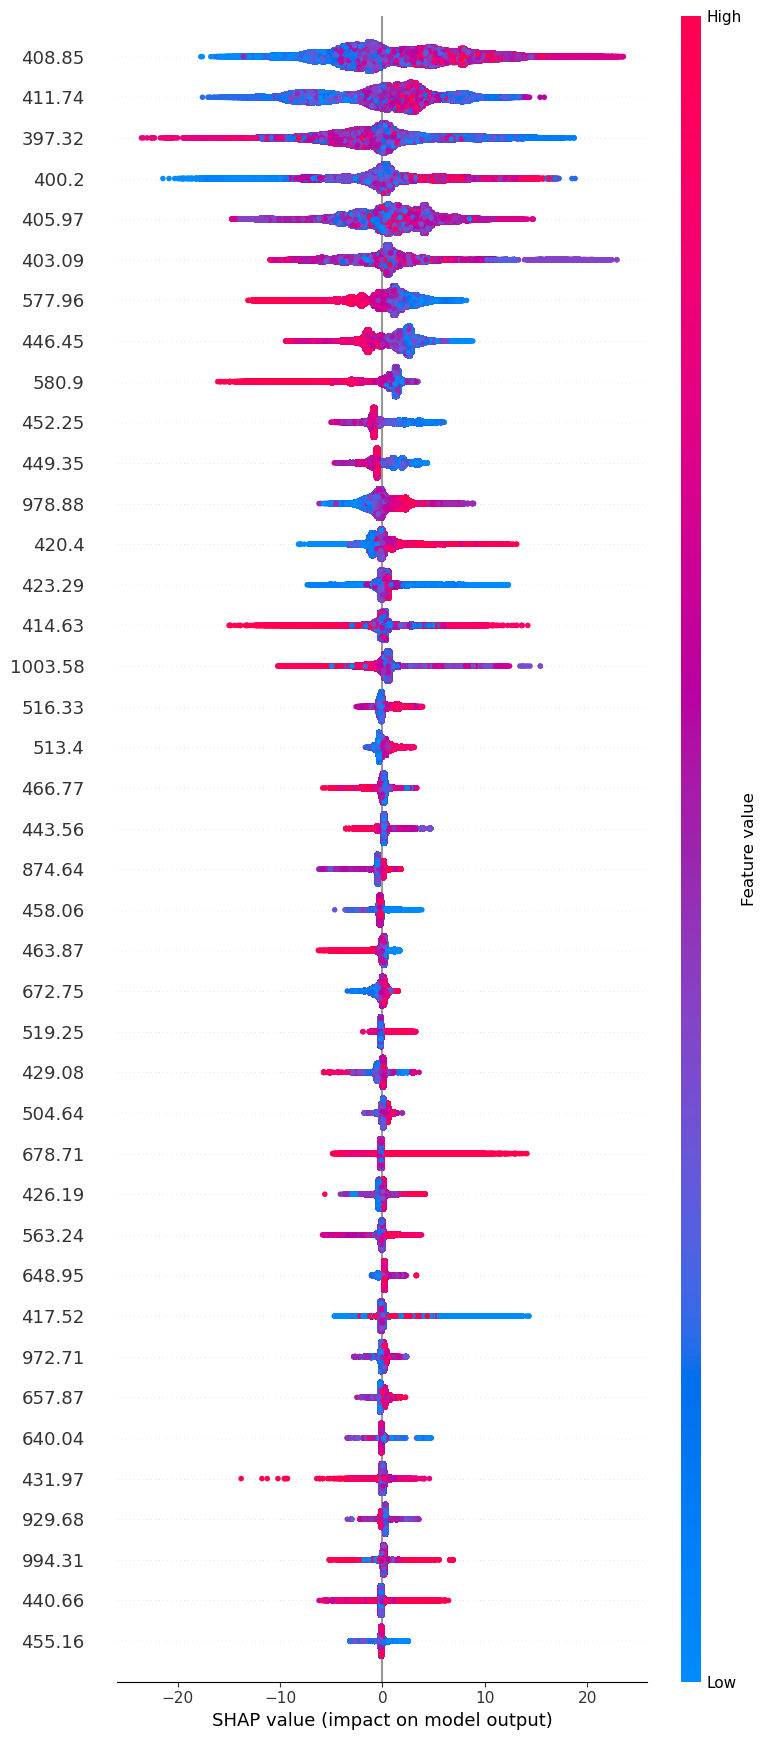

In [25]:
# XGBoost
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=40)

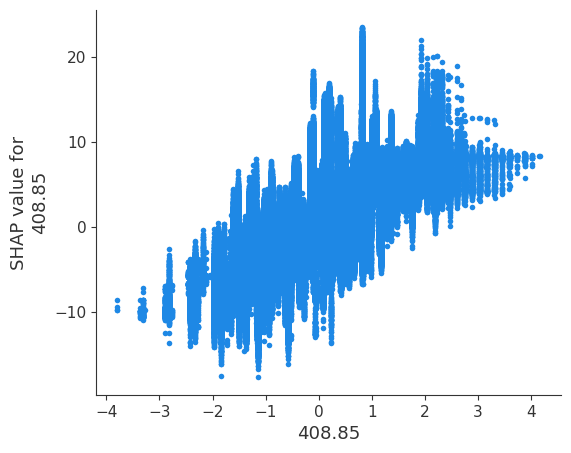

In [24]:
# The dependence plot shows the relationship between the SHAP value of a single feature 
# and the feature value itself, highlighting interactions with other features.
shap.initjs()
shap.dependence_plot("rank(0)", shap_values.values, X_test, feature_names=BANDS_WAVELENGTHS, interaction_index=None)
# interaction_index“auto”, None, int, or string
# The index of the feature used to color the plot. The name of a feature can also be passed as a string. If “auto” then shap.common.approximate_interactions
# is used to pick what seems to be the strongest interaction (note that to find to true stongest interaction you need to compute the SHAP interaction values).


In [19]:
# The force plot provides a detailed explanation for a single prediction, 
# showing how each feature contributes to pushing the prediction from the base value to the final prediction.
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_test[0, :], feature_names=BANDS_WAVELENGTHS)

In [ ]:
# Random Forest
# The summary plot gives a global overview of the feature importance 
# and the effects of the features on the model's predictions.
shap.summary_plot(shap_values, X_test, feature_names=BANDS_WAVELENGTHS, max_display=40)

In [8]:
accuracy_list = []
for i in num_irrelevant_features_eliminated:
    rfe = RFE(model, n_features_to_select=(total_features - i))
    rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)
    accuracy = MSE(y_test, y_pred)
    accuracy_list.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(num_irrelevant_features_eliminated, accuracy_list, marker='o')
plt.xlabel("Number of Irrelevant Features Eliminated")
plt.ylabel("Accuracy")
plt.title("Model Performance as Irrelevant Features are Eliminated (RFE)")
plt.grid(True)
plt.show()

## PCA

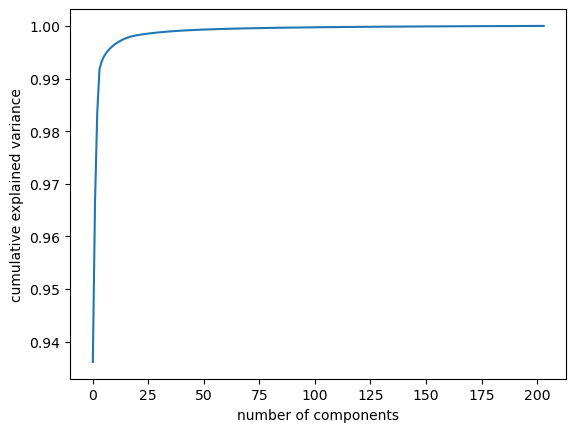

In [5]:
PCA_model = PCA()
PCA_model.fit(X_train)
# visualize the selelcted components
plt.plot(np.cumsum(PCA_model.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## Random Forest

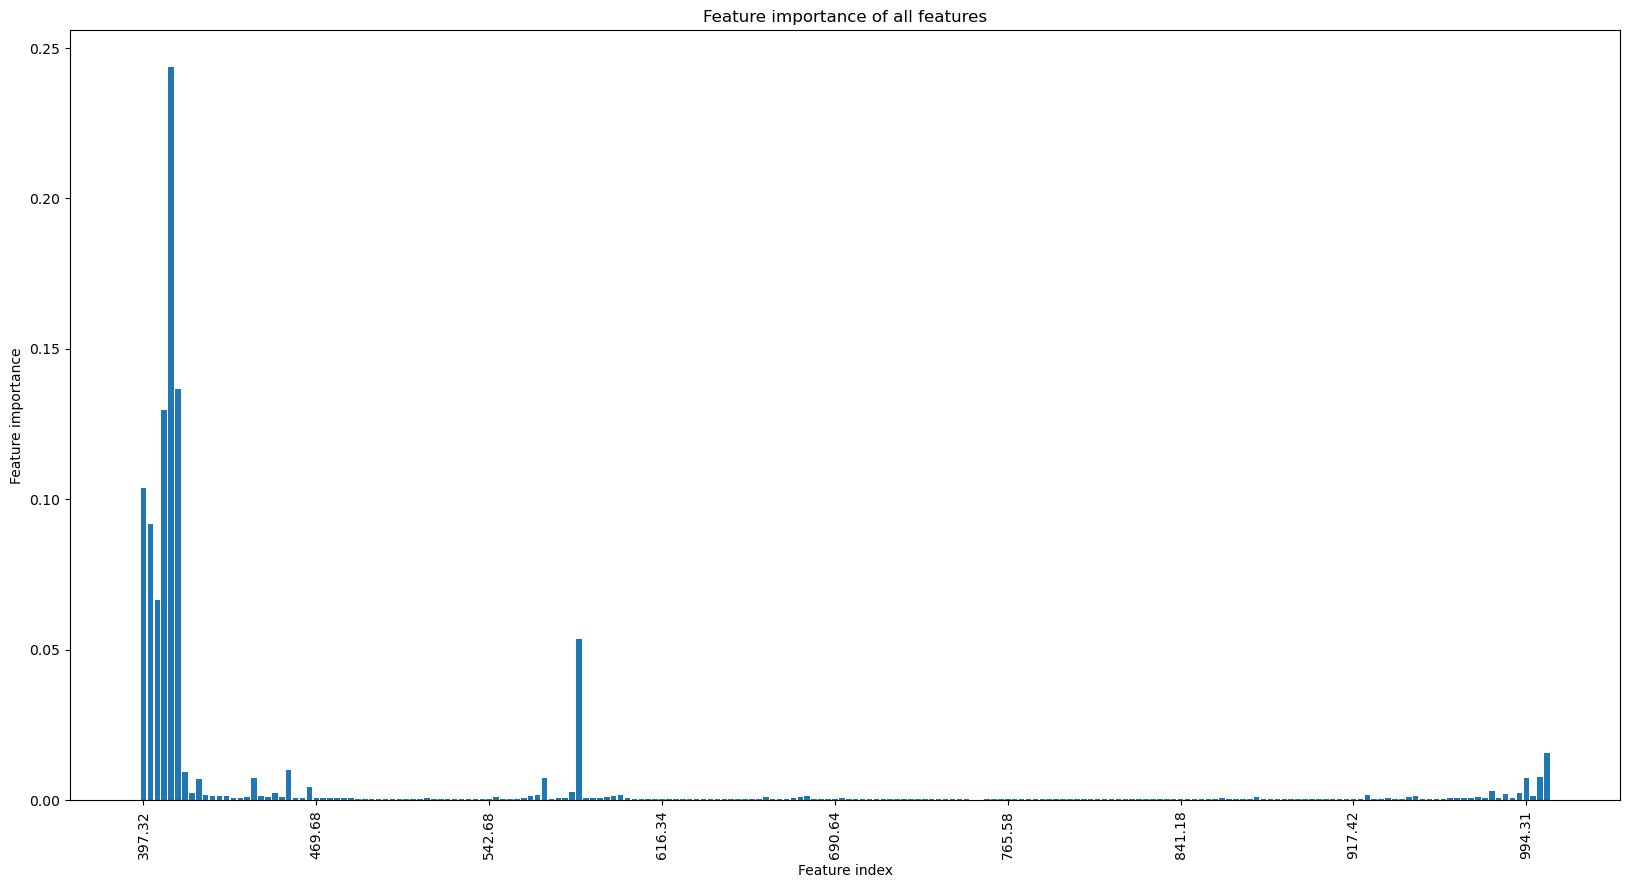

Top 49 features: [  4   5   3   0   1   2  63 203  21   6 202  58 200  16   8  24 195  62
  19   7 199 197   9  57  69 177 184 201  12  17  10  68  96  56  11  15
 161  95 183  67  18  51  90 193  20  27  13 194  14]


In [7]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Visualize feature importance
plt.figure(figsize=(20, 10))
plt.bar(range(len(BANDS_WAVELENGTHS)), rf_model.feature_importances_)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.xticks(range(0, 204, 25), BANDS_WAVELENGTHS[0::25], rotation=90)
plt.title("Feature importance of all features")
plt.show()

# Select top features
top_idx = np.argsort(rf_model.feature_importances_)[::-1][:num_features_to_select]
print(f"Top {num_features_to_select} features: {top_idx}")

## XGBoost

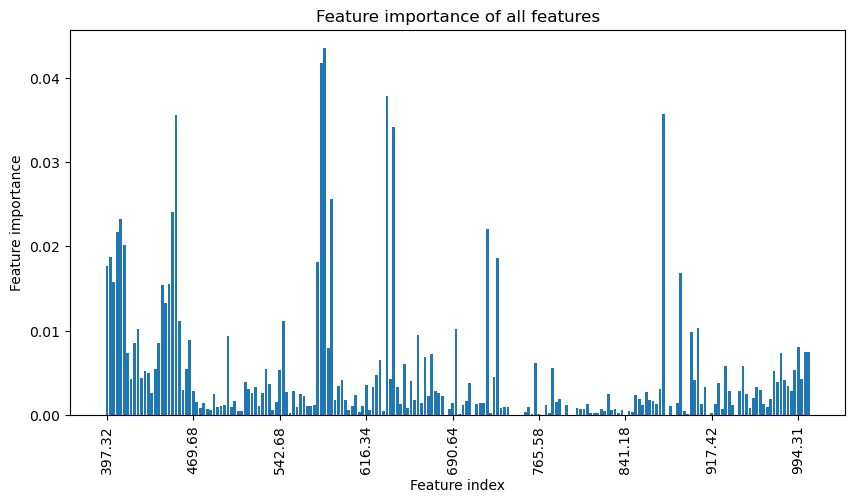

Top 49 features: [ 63  62  81 161  20  83  65  19   4 110   3   5   1 113  61   0 166   2
  18  16  17  51  21 171 101   9 169  90  35  24  15   8 200  64 202 203
 195   6  94  92  79 124  86 184 179 129  23  14  46]


In [8]:
# Robust Scaler, without x_val
xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Visualize feature importance
plt.figure(figsize=(10, 5))
plt.bar(range(len(BANDS_WAVELENGTHS)), xgb_model.feature_importances_)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.xticks(range(0, 204, 25), BANDS_WAVELENGTHS[0::25], rotation=90)
plt.title("Feature importance of all features")
plt.show()

# Select top features
top_idx = np.argsort(xgb_model.feature_importances_)[::-1][:num_features_to_select]
print(f"Top {num_features_to_select} features: {top_idx}")

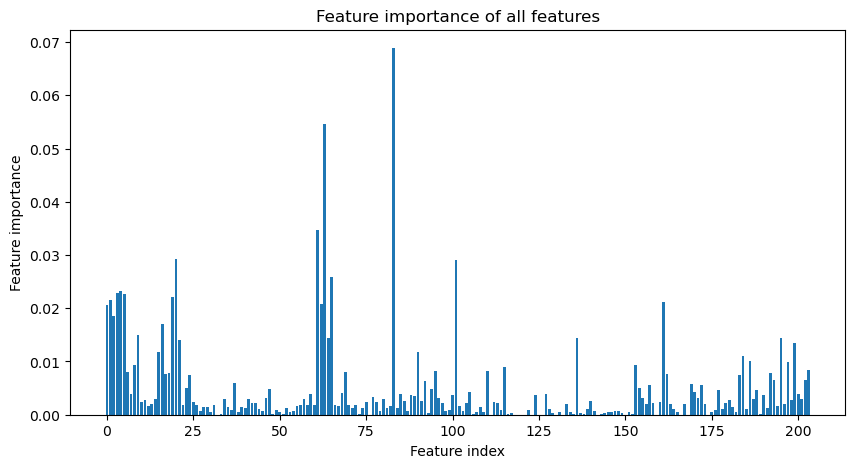

Top 20 features:  [ 83  63  61  20 101  65   4   3   5  19   1 161  62   0   2  16   9 195
 136  64  21 199  90  15 184 186 197   8 153 115 203  95 110  69   6 192
  18 162  17 183  24 202 193  92  37 169 172 157 154  23]


In [16]:
# Standard scaler, without x_val
xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Visualize feature importance
plt.figure(figsize=(10, 5))
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.title("Feature importance of all features")
plt.show()

# Select top 20 features
top_50_idx = np.argsort(xgb_model.feature_importances_)[::-1][:50]
print("Top 50 features: ", top_50_idx)

## Lasso Regression

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
..............................[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed: 22.9min remaining: 34.4min
..............................[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 23.5min finished


LassoCV model fit complete...
X_train_selected shape:  (4088984, 20)
X_val_selected shape:  (1752422, 20)
X_test_selected shape:  (1540764, 20)


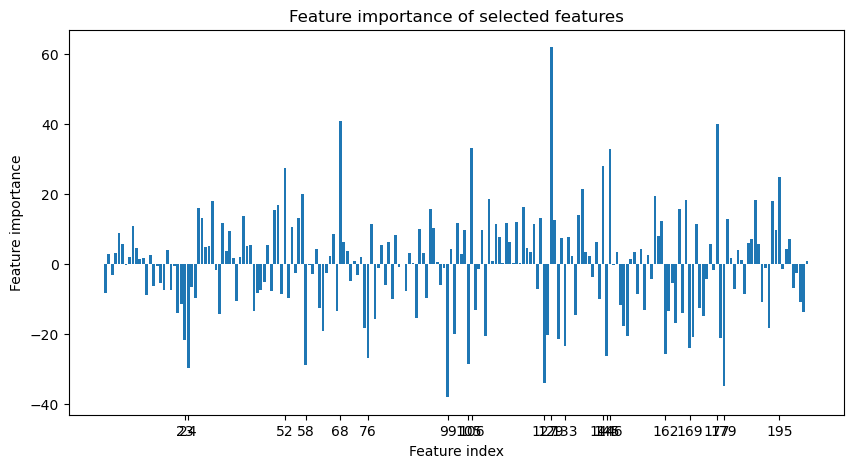

Selected features:  [ 23  24  52  58  68  76  99 105 106 127 129 133 144 145 146 162 169 177
 179 195]


In [17]:
# Fit LassoCV model 
lasso_cv = LassoCV(cv=10, random_state=42, verbose=True, alphas=[0.0001, 0.001, 0.01, 0.1, 1, 5], n_jobs=-1)
lasso_cv.fit(X_train, y_train)

print("LassoCV model fit complete...")
# Feature selection 
sfm = SelectFromModel(lasso_cv, prefit=True, threshold=-np.inf, max_features=num_features_to_select) 
X_train = sfm.transform(X_train) 
X_val = sfm.transform(X_val)
X_test = sfm.transform(X_test)

# Show dimensions of data after LassoCV
print("X_train_selected shape: ", X_train.shape)
print("X_val_selected shape: ", X_val.shape)
print("X_test_selected shape: ", X_test.shape)

feature_indices = np.array(range(len(lasso_cv.coef_)))

# Analyze selected features and their importance 
selected_feature_indices = np.where(sfm.get_support())[0] 
selected_features = feature_indices[selected_feature_indices] 
coefficients = lasso_cv.coef_ 

# Visualize selected features and their importance
plt.figure(figsize=(10, 5))
plt.bar(feature_indices, coefficients)
plt.xticks(selected_features)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.title("Feature importance of selected features")
plt.show()

# Show selected features
print("Selected features: ", selected_feature_indices)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
........................[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  5.6min remaining:  8.4min
....................................[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.8min finished


LassoCV model fit complete...
X_train_selected shape:  (4088984, 50)
X_val_selected shape:  (1752422, 50)
X_test_selected shape:  (1540764, 50)


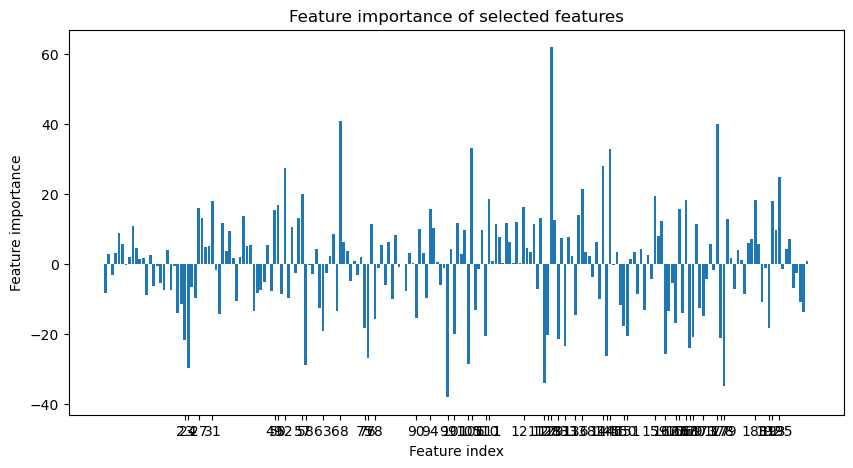

Selected features:  [ 23  24  27  31  49  50  52  57  58  63  68  75  76  78  90  94  99 101
 105 106 110 111 121 127 128 129 131 133 136 138 144 145 146 150 151 159
 162 165 166 168 169 170 173 177 178 179 188 192 193 195]


In [17]:
# Fit LassoCV model 
lasso_cv = LassoCV(cv=10, random_state=42, verbose=True, alphas=[0.0001, 0.001, 0.01, 0.1, 1, 5], n_jobs=-1)
lasso_cv.fit(X_train, y_train)

print("LassoCV model fit complete...")
# Feature selection 
sfm = SelectFromModel(lasso_cv, prefit=True, threshold=-np.inf, max_features=num_features_to_select) 
X_train = sfm.transform(X_train) 
X_val = sfm.transform(X_val)
X_test = sfm.transform(X_test)

# Show dimensions of data after LassoCV
print("X_train_selected shape: ", X_train.shape)
print("X_val_selected shape: ", X_val.shape)
print("X_test_selected shape: ", X_test.shape)

feature_indices = np.array(range(len(lasso_cv.coef_)))

# Analyze selected features and their importance 
selected_feature_indices = np.where(sfm.get_support())[0] 
selected_features = feature_indices[selected_feature_indices] 
coefficients = lasso_cv.coef_ 

# Visualize selected features and their importance
plt.figure(figsize=(10, 5))
plt.bar(feature_indices, coefficients)
plt.xticks(selected_features)
plt.xlabel("Feature index")
plt.ylabel("Feature importance")
plt.title("Feature importance of selected features")
plt.show()

# Show selected features
print("Selected features: ", selected_feature_indices)